In [1]:
import numpy as np
import pandas as pd

In [11]:
import os
def combine_and_merge(root_folder1, root_folder2, common_column, merge_how='inner'):
    """
    Combines CSVs from two separate root folders and merges the resulting DataFrames.

    Args:
        root_folder1 (str): Path to the first folder containing CSV files.
        root_folder2 (str): Path to the second folder containing CSV files.
        common_column (str): Column to merge the DataFrames on.
        merge_how (str): Merge method ('inner', 'outer', 'left', 'right'). 'I am using inner'

    Returns:
        pd.DataFrame: Merged DataFrame.
    """
    def combine_csvs(root):
        combined_list = []
        for subdir, _, files in os.walk(root):
            for file in files:
                if file.endswith('.csv'):
                    file_path = os.path.join(subdir, file)
                    try:
                        df = pd.read_csv(file_path)
                        combined_list.append(df)
                    except Exception as e:
                        print(f"Skipping {file_path}: {e}")
        if not combined_list:
            raise ValueError(f"No CSV files found in {root}")
        return pd.concat(combined_list, ignore_index=True)

    # Combining both sets
    df1 = combine_csvs(root_folder1)
    df2 = combine_csvs(root_folder2)

    # Merge on the specified column
    merged_df = pd.merge(df1, df2, on=common_column, how=merge_how)
    return merged_df

In [12]:
merged_df = combine_and_merge(
    root_folder1='GHI',
    root_folder2='PR',
    common_column='Date',
    merge_how='inner'  
)
print(merged_df.head())


         Date       GHI         PR
0  2019-07-01  3.256608  69.575676
1  2019-07-02  3.976767  79.314411
2  2019-07-03  2.811867  61.020006
3  2019-07-04  3.658408  83.262576
4  2019-07-05  5.590683  82.124440


In [13]:
merged_df

,Date,GHI,PR
0,2019-07-01,3.256608,69.575676
1,2019-07-02,3.976767,79.314411
2,2019-07-03,2.811867,61.020006
3,2019-07-04,3.658408,83.262576
4,2019-07-05,5.590683,82.124440
...,...,...,...
977,2022-03-20,4.226183,81.632738
978,2022-03-21,3.431675,71.057353
979,2022-03-22,3.580492,81.631509
980,2022-03-23,4.997617,71.906149


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_performance_evolution(df, start_date=None, end_date=None):
    """
    Plotting Performance Ratio (PR) evolution with moving average, budget line, GHI color-coded scatter,
    and percentage of points above budget.

    Args:
        df (pd.DataFrame): DataFrame with columns 'Date', 'GHI', 'PR'.
        start_date (str or None): Optional start date filter (YYYY-MM-DD).
        end_date (str or None): Optional end date filter (YYYY-MM-DD).
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df.set_index('Date', inplace=True)

    if start_date:
        start_date = pd.to_datetime(start_date)
        df = df.loc[df.index >= start_date]
    if end_date:
        end_date = pd.to_datetime(end_date)
        df = df.loc[df.index <= end_date]

    if df.empty:
        print("No data available for the specified date range.")
        return

    # Calculate 30-day moving average
    df['pr_30d_avg'] = df['PR'].rolling(window=30, min_periods=1).mean()

    # Budget PR calculation starting July 1, 2019
    budget_start = pd.Timestamp(start_date)
    budget_end = df.index.max()
    years = pd.date_range(start=budget_start, end=budget_end, freq='12MS')

    budget_values = []
    for i in range(len(years)):
        period_start = years[i]
        period_end = years[i + 1] if i + 1 < len(years) else budget_end
        budget_pr = 73.9 * ((1 - 0.008) ** i)
        date_range = pd.date_range(start=period_start, end=period_end, freq='D')
        budget_values.extend([(d, budget_pr) for d in date_range])

    budget_df = pd.DataFrame(budget_values, columns=['Date', 'budget_pr']).set_index('Date')
    df = df.join(budget_df, how='left')

    def ghi_color(val):
        if val < 2:
            return 'navy'
        elif 2 <= val < 4:
            return 'lightblue'
        elif 4 <= val < 6:
            return 'orange'
        else:
            return 'brown'

    df['color'] = df['GHI'].apply(ghi_color)

    # Plot
    plt.figure(figsize=(16, 8))
    plt.title("Performance Evolution")

    plt.scatter(df.index, df['PR'], c=df['color'], s=30, edgecolors='face', label='Daily PR')
    plt.plot(df.index, df['pr_30d_avg'], color='red', linewidth=2, label='30-day PR Avg')
    plt.plot(df.index, df['budget_pr'], color='darkgreen', linewidth=2, label='Budget PR')

    # Points above budget
    above_budget = df[df['PR'] > df['budget_pr']]
    plt.scatter(above_budget.index, above_budget['PR'], facecolors='none', edgecolors='black', s=80, label='PR > Budget')

    # Calculate stats and percentage
    stats_days = [7, 30, 60, 90]
    stats_text = "\n".join(
        [f"Avg PR Last {d}d: {df['PR'].last(f'{d}D').mean():.2f}" for d in stats_days]
    )

    percentage_above = (len(above_budget) / len(df)) * 100
    stats_text += f"\n\n{percentage_above:.2f}% of PR points are above Budget PR"

    # Display stats
    ymin, ymax = plt.ylim()
    xmax = df.index.max()
    plt.text(xmax, ymin + 0.05*(ymax - ymin), stats_text,
             fontsize=10, verticalalignment='bottom', horizontalalignment='right',
             bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8))

    plt.xlabel("Date")
    plt.ylabel("PR")
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)

    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

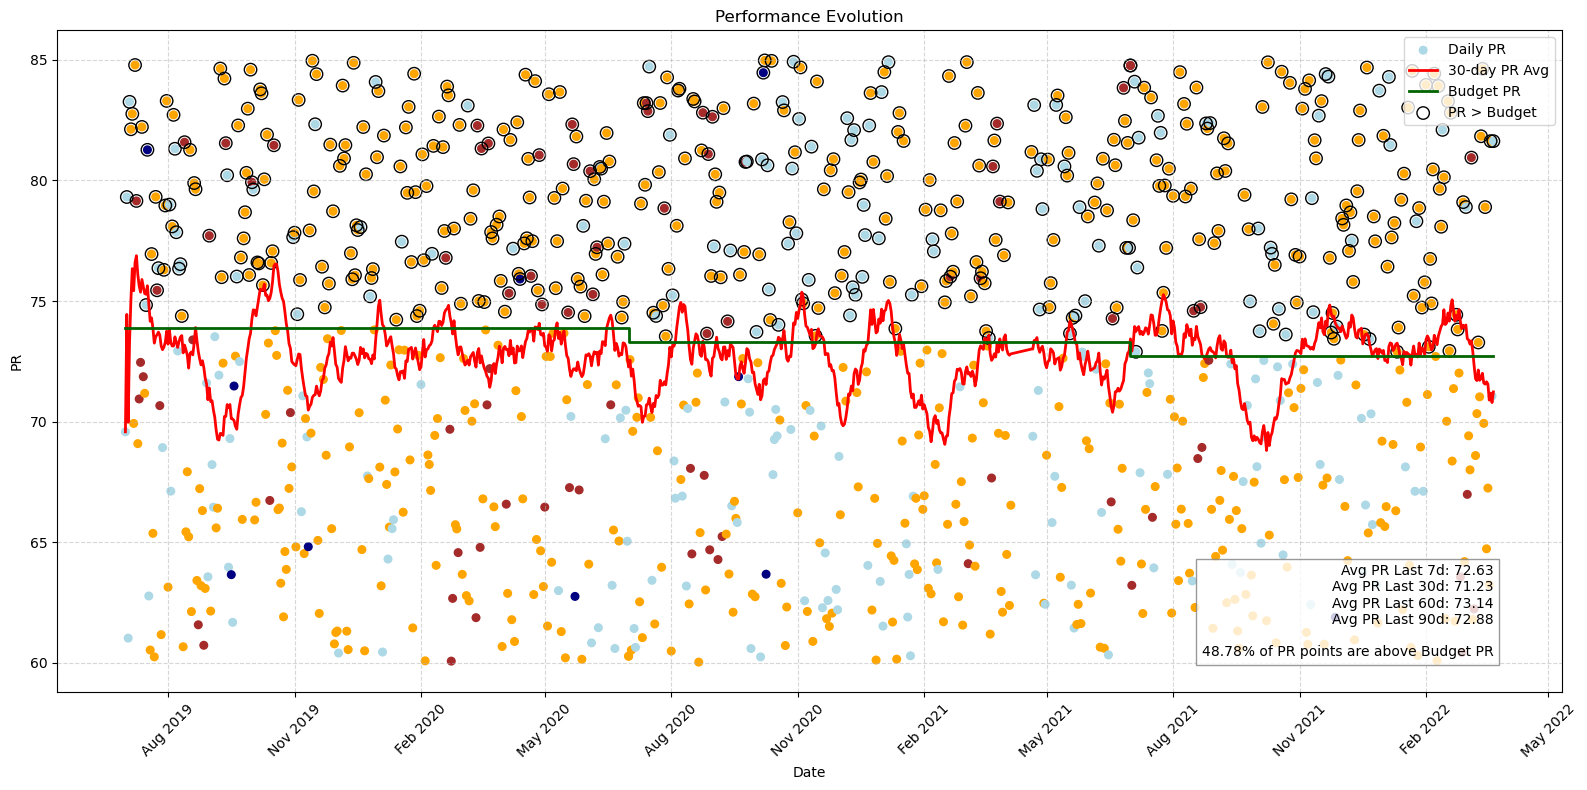

In [15]:
plot_performance_evolution(merged_df, start_date='2019-07-01', end_date='2022-03-22')